# Mètodes tradicionals per a la classificació

- [Mètodes auxiliars](#aux)
- [Extracció de datasets](#extract)
- [Separació de colors per OHTA](#ohta)
- [Separació de colors per HSV](#hsv)
- [Histogrames](#hist)
    - [Estadístiques dels datasets](#hist_stat)
- [HOG](#hog)
    - [Classificació HOG per SVM](#hog_svm)
- [Color dominant](#dom_col)
- [Estadístiques color dominant](#color_data)
    - [Classificació color per LVQ](#lvm_color_data)
- [Segmentació per color](#col_seg)
- [Filtres de Gabor](#gabor)
- [Segmentació color per LUT](#lut)
- [Segmentació color per Gauss](#gauss)
- [Descriptor de contorn](#contorn)
- [SVM](#SVM)
    - [Classificació amb una única SVM](#1svm)
    - [Classificació amb SVM's per color](#3svm)
        - [Blaus](#blaus)
        - [Vermells](#vermells)
        - [Grocs](#grocs)
    

In [1]:
import os
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt

## Definició de funcions auxiliars <a name="aux"></a>

In [2]:
#Funció auxiliar per imprimir múltiples imatges
def print_images(images, titles=None, ncols=None, colormap=None):
    if ncols == None: #If no number of columns is given, we will print everything in one row
        ncols = len(images)
    if titles == None or len(titles) != len(images): #Empty titles if no titles given or dimension mismatch 
        titles = ["" for i in range(len(images))]
    
    nrows = math.ceil(len(images)/ncols) #Compute the number of rows required to print everythong in ncols
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False, figsize=(13,13)) #Generate subplot
    
    #Switch off every axis
    for x in ax.ravel():
        x.axis("off")
        
    for i in range(nrows):
        for j in range(ncols):
            if i*ncols + j >= len(images): #Stop if every image has been printed, even if the grid is not "complete"
                break;
            ax[i,j].imshow(images[i*ncols + j], cmap=colormap) #Set subplot with given colormap
            ax[i,j].set_title(titles[i*ncols + j])
    plt.show() #Show subplots
    return

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          integer=False,
                          title='Matriu de confussió',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, int(cm[i, j]) if integer else round(cm[i,j], 2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Classe real')
    plt.xlabel('Classe predita')

## Extracció del dataset manual de senyals <a name="extract"></a>

In [4]:
#! tar -xf../input/ts-patches/manual_dataset.tar.xz
#! tar -xf../input/mixedts/MixedTS.tar.xz
#! tar -xf ../input/mixedts-colors/MixedTS_colors.tar.xz
! tar -xf ../../datasets/MixedTS_colors.tar.xz

In [5]:
!cp -r MixedTS_colors/no_senyal/ MixedTS_colors/blue/
!cp -r MixedTS_colors/no_senyal/ MixedTS_colors/red/
!cp -r MixedTS_colors/no_senyal/ MixedTS_colors/yellow/

## Thresholds pel sistema de representació de color Ohta <a name="ohta"></a>

In [8]:
#Llibreries necessàries per fer els widgets interactius pels thresholds
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import os

In [33]:
@interact
def filter_color_ohta(name=os.listdir('./manual_dataset/limit_10/'),
                     th1=widgets.FloatSlider(value=0.0,min=-0.1,max=0.1, step=0.005,description='th1: '),
                     th2=widgets.FloatSlider(value=0.0,min=-0.1,max=0.1, step=0.005,description='th2: '),
                     second_abs=widgets.ToggleButton(value=True)):
    im = cv2.imread('./manual_dataset/limit_10/' + name)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = im/255
    ohta1 = (im[:, :, 0] - im[:, :, 2])/(np.sum(im, axis=2)*math.sqrt(2))
    ohta2 = (2*im[:, :, 1] - im[:, :, 0] - im[:, :, 2])/(np.sum(im, axis=2)*math.sqrt(6))
    ohta = np.stack((ohta1, ohta2), axis=2)
    print(ohta.shape)
    mask = np.logical_and(ohta[:, :, 0] >= th1, ohta[:, :, 1] <= th2)
    binary = np.zeros(im.shape[:-1])
    binary[mask] = 1
    plt.imshow(mask)

interactive(children=(Dropdown(description='name', options=('bar_00099.jpeg', 'bar_00253.jpeg', 'bar_00415.jpe…

In [5]:
im = cv2.imread("bar_00377.jpeg")
#im = cv2.imread("bar_00581.jpeg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = im/255
ohta1 = (im[:, :, 0] - im[:, :, 2])/(np.sum(im, axis=2)*math.sqrt(2))
ohta2 = (2*im[:, :, 1] - im[:, :, 0] - im[:, :, 2])/(np.sum(im, axis=2)*math.sqrt(6))
ohta = np.stack((ohta1, ohta2), axis=2)
print(ohta.shape)
mask = np.logical_and(ohta[:, :, 0] >= -0.01, ohta[:, :, 1] <= -0.02)
binary = np.zeros(im.shape[:-1], np.uint8)
binary[mask] = 255

out = cv2.connectedComponentsWithStats(binary, 4)
num_labels = out[0]
labels = out[1]
stats = out[2]
centroids = out[3]
plt.imshow(labels, cmap='gray')
print(stats)

error: OpenCV(4.5.4) /tmp/pip-req-build-jpmv6t9_/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


## Thresholds per HSV <a name="hsv"></a>

In [113]:
@interact
def filter_color_hsv(name=os.listdir('./manual_dataset/prohibit_girar_esquerra/'), 
                 h=widgets.IntRangeSlider(value=[0, 179],min=0,max=179,step=1, description='Hue:'),
                 s=widgets.IntRangeSlider(value=[0, 255],min=0,max=255,step=1, description='Sat:'), 
                 v=widgets.IntRangeSlider(value=[0, 255],min=0,max=255,step=1, description='Val:'),
                 invert=widgets.ToggleButton(value=False)):
    im = cv2.imread('./manual_dataset/prohibit_girar_esquerra/gir_00038.jpeg')
    if invert:
        im = cv2.bitwise_not(im)
    im_hsv = cv2.cvtColor(im,  cv2.COLOR_BGR2HSV)
    lower1 = np.array([h[0], s[0], v[0]])
    upper1 = np.array([h[1], s[1], v[1]])

    mask = cv2.inRange(im_hsv, lower1, upper1)
  
    plt.imshow(mask)

interactive(children=(Dropdown(description='name', options=('gir_00256.jpeg', 'gir_00854.jpeg', 'gir_01060.jpe…

In [34]:
im = cv2.imread("02676.jpeg")
im = cv2.bitwise_not(im)
im_hsv = cv2.cvtColor(im,  cv2.COLOR_BGR2HSV)
mask = cv2.inRange(im_hsv, (90 - 5, 70, 50), (90 + 5, 255, 255))

  
plt.imshow(mask)

error: OpenCV(4.5.4) /tmp/pip-req-build-jpmv6t9_/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


## Histogrames <a name="hist"></a>

In [5]:
im = cv2.imread("00376.jpeg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
mean = cv2.mean(im)
print(mean)

error: OpenCV(4.5.4) /tmp/pip-req-build-jpmv6t9_/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [6]:
#Funcions auxiliars per calcular i imprimir histogrames
def hsv_hist(im):
    hist_h = cv2.calcHist([im], [0], None, [180], [0,179])
    hist_s = cv2.calcHist([im], [1], None, [256], [0,255])
    hist_v = cv2.calcHist([im], [2], None, [256], [0,255])
    
    return (hist_h, hist_s, hist_v)

def plt_hist(hist):
    plt.plot(hist[0], 'r')
    plt.plot(hist[1], 'g')
    plt.plot(hist[2], 'b')
    plt.show()


### Dades estadístiques dels datasets <a name="hist_stat"></a>

In [7]:
import os
def load_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            images.append(img)
    return images

total_hist = np.array([np.zeros((180,1)), np.zeros((256,1)), np.zeros((256,1))])
#otal_hist = np.sum([total_hist, hsv_hist(image)], axis=0)
images = load_folder("./prohibit_aparcar/")
for image in images:
    total_hist = np.sum([total_hist, hsv_hist(image)], axis=0)
    
total_hist = total_hist/len(images)
#print(total_hist[0].shape)
print(np.argmax(total_hist[0]))

plt_hist(total_hist)

    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # This is added back by InteractiveShellApp.init_path()


FileNotFoundError: [Errno 2] No such file or directory: './prohibit_aparcar/'

## Intents HOG + SVM <a name="hog"></a>

In [8]:
#Funció auxiliar pel càlcul de HOG
def hog(img, bin_n=16):
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
    mag, ang = cv2.cartToPolar(gx, gy)
    bins = np.int32(bin_n*ang/(2*np.pi))    # quantizing binvalues in (0...16)
    bin_cells = bins[:10,:10], bins[10:,:10], bins[:10,10:], bins[10:,10:]
    mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
    hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
    hist = np.hstack(hists)# hist tindrà mida 16*4
    return hist

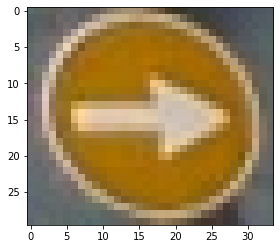

In [7]:
#im = cv2.imread("./manual_dataset/obligacio_recte/bar_00216.jpeg")
im = cv2.imread("./manual_dataset/obligacio_esq/00031.jpeg")
plt.imshow(im)

In [30]:
data_path = "./manual_dataset/"

images = []
labels = []

dirs = sorted(os.listdir(data_path))
for i, folder in enumerate(dirs):
    print(i, folder)
    for filename in os.listdir(data_path + folder):
        img = cv2.imread(os.path.join(data_path + folder,filename))
        if img is not None:
            img = cv2.resize(img, (32,32))
            images.append(hog(img))
            labels.append(i)


0 8t
1 aparcament
2 limit_10
3 limit_30
4 no_senyal
5 obligacio_esq
6 obligacio_esq_davant
7 obligacio_esq_dreta
8 obligacio_recte
9 pas_vianants
10 prohibit_aparcar
11 prohibit_girar_esquerra
12 prohibit_parar_estacionar
13 prohibit_passar
14 stop


In [28]:
np_hogs = np.float32(images)
np_labels = np.array(labels)

In [47]:
print(np_labels.size)

3687


### Classificació per HOG i SVM <a name="hog_svm"></a>

In [48]:
# Partim el conjunt de hogs i etiquetes en el conjunt d'entrenament i avaluació
rand = np.random.RandomState(42)
shuffle = rand.permutation(np_labels.size)
np_hogs_sh = np_hogs[shuffle]
np_labels_sh = np_labels[shuffle]

train_hogs = np_hogs_sh[:3000]
test_hogs = np_hogs_sh[3000:]

train_labels = np_labels_sh[:3000]
test_labels = np_labels_sh[3000:]

In [49]:
svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_LINEAR) # amb cv2.ml.SVM_RBF funciona fatal
svm.setGamma(5.383)
svm.setC(2.67)
# svm.setNu(0.0)
# svm.setP(0.0)
# svm.setClassWeights(None)

#Entrenem la SVM i guardem els paràmetres
svm.train(train_hogs, cv2.ml.ROW_SAMPLE, train_labels)
svm.save('svm_data_linear.dat')

In [50]:
# Fem la predicció
resp = svm.predict(test_hogs)[1].ravel()

In [51]:
# Calculem el percentatge d'errors 
error = (test_labels != resp).mean()
print(error*100)

2.4745269286754


In [52]:
# Calculem la matriu de confussió
confussion = np.zeros((15,15))
for i, j in zip(test_labels, resp):
    confussion[i,int(j)] += 1

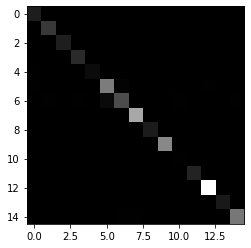

In [53]:
# Imprimim la matriu de confussió
plt.imshow(confussion, cmap='gray')

### Validating with GTSRB

#### Equivalències de classes entre els patches i GTSRB
|classe|patches|gtsrb|
|:----:|:-----:|:---:|
| 8t | 0 | - |
| aparcament | 1 | - |
| limit_10 | 2 | - |
| limit_30 | 3 | 1 |
| no_senyal | 4 | - |
| obligacio_esq | 5 | 34 |
| obligacio_esq_davant | 6 | 37 |
| obligacio_esq_dreta | 7 | - |
| obligacio_recte | 8 | 35 |
| pas_vianants | 9 | - |
| prohibit_aparcar | 10 | - |
| prohibit_girar_esquerra | 11 | - |
| prohibit_parar_estacionar | 12 | - |
| prohibit_passar | 13 | 17 |
| stop | 14 | 14 |


In [31]:
patch_to_gtsrb = {
    8: 35,
    5: 34,
    6: 37,
    14: 14,
    3: 1,
    13: 17
},
gtsrb_to_patch = {
    35: 8,
    34: 5,
    37: 6,
    14: 14,
    1: 3,
    17: 13
}

In [32]:
import pandas as pd

gtrsb_indices = []
gtrsb_hogs = []
gtrsb_paths = []

existing_categories = set([35, 34, 37, 14, 1, 17])

data = pd.read_csv(r'../input/gtsrb-german-traffic-sign/Test.csv')
df = pd.DataFrame(data, columns=['ClassId', 'Path'])
for i, row in df.iterrows():
    if row[0] in existing_categories:
        img = cv2.imread("../input/gtsrb-german-traffic-sign/" + row[1])
        img = cv2.resize(img, (32,32))
        gtrsb_hogs.append(hog(img))
        gtrsb_indices.append(gtsrb_to_patch[row[0]])
        gtrsb_paths.append(row[1])

Error:  89.16666666666667 %


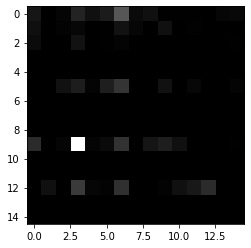

In [84]:
resp_gtsrb = svm2.predict(np.float32(gtrsb_hogs))[1].ravel()
resp_patch = [patch_to_gtsrb[i] if i in patch_to_gtsrb else -1 for i in resp_gtsrb]

def print_image_class(i):
    img = cv2.imread("../input/gtsrb-german-traffic-sign/" + gtrsb_paths[i])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    print(resp_gtsrb[i])

    
error3 = (gtrsb_indices != resp_gtsrb).mean()
print("Error: ", error3*100, "%")
confussion3 = np.zeros((15,15))
for i, j in zip(gtrsb_indices, resp_gtsrb):
    confussion3[i,int(j)] += 1
plt.imshow(confussion3, cmap='gray')

__Conclusió:__ fent-ho amb les imatges de les mateixes categories però GTSRB funciona fatal. Probablement és perquè la bounding box de les imatges que dóna GTSRB són més grans que les senyals, mentre que als patches del nostre dataset són més petits que les pròpies senyals. Una possible solució és fer més petita les bounding boxes segmentant per color (com a [aqui](https://stackoverflow.com/questions/50051916/bounding-box-on-objects-based-on-color-python)). L'altra possibilitat és fer data augmentation sobre el dataset de patches.

## Colors Dominants <a name="dom_col"></a>

h shape:  (41, 36)
Mask shape:  (41, 36)
Blob shape: (41, 36, 3)


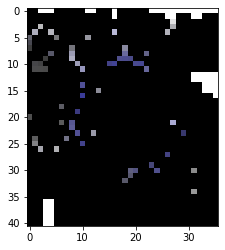

Found hue 0 in region (3, 36, 2, 5).
(5, 2, 3)
(5, 2)
 * wrote 'colourblobs-0-hue_000-region_0-section.png'
 * wrote 'colourblobs-0-hue_000-region_0-bbox.png'
Found hue 0 in region (31, 34, 1, 1).
(1, 1, 3)
(1, 1)
 * wrote 'colourblobs-0-hue_000-region_1-section.png'
 * wrote 'colourblobs-0-hue_000-region_1-bbox.png'
Found hue 0 in region (31, 30, 1, 1).
(1, 1, 3)
(1, 1)
 * wrote 'colourblobs-0-hue_000-region_2-section.png'
 * wrote 'colourblobs-0-hue_000-region_2-bbox.png'
Found hue 0 in region (18, 30, 3, 3).
(3, 3, 3)
(3, 3)
 * wrote 'colourblobs-0-hue_000-region_3-section.png'
 * wrote 'colourblobs-0-hue_000-region_3-bbox.png'
Found hue 0 in region (23, 29, 2, 2).
(2, 2, 3)
(2, 2)
 * wrote 'colourblobs-0-hue_000-region_4-section.png'
 * wrote 'colourblobs-0-hue_000-region_4-bbox.png'
Found hue 0 in region (26, 27, 1, 1).
(1, 1, 3)
(1, 1)
 * wrote 'colourblobs-0-hue_000-region_5-section.png'
 * wrote 'colourblobs-0-hue_000-region_5-bbox.png'
Found hue 0 in region (5, 26, 1, 1).
(1, 

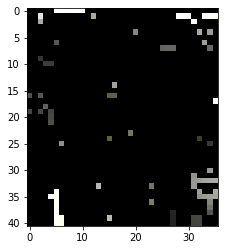

Found hue 90 in region (31, 39, 2, 2).
(2, 2, 3)
(2, 2)
 * wrote 'colourblobs-1-hue_090-region_0-section.png'
 * wrote 'colourblobs-1-hue_090-region_0-bbox.png'
Found hue 90 in region (15, 39, 1, 1).
(1, 1, 3)
(1, 1)
 * wrote 'colourblobs-1-hue_090-region_1-section.png'
 * wrote 'colourblobs-1-hue_090-region_1-bbox.png'
Found hue 90 in region (27, 38, 1, 3).
(3, 1, 3)
(3, 1)
 * wrote 'colourblobs-1-hue_090-region_2-section.png'
 * wrote 'colourblobs-1-hue_090-region_2-bbox.png'
Found hue 90 in region (23, 36, 1, 1).
(1, 1, 3)
(1, 1)
 * wrote 'colourblobs-1-hue_090-region_3-section.png'
 * wrote 'colourblobs-1-hue_090-region_3-bbox.png'
Found hue 90 in region (4, 34, 3, 7).
(7, 3, 3)
(7, 3)
 * wrote 'colourblobs-1-hue_090-region_4-section.png'
 * wrote 'colourblobs-1-hue_090-region_4-bbox.png'
Found hue 90 in region (23, 33, 1, 1).
(1, 1, 3)
(1, 1)
 * wrote 'colourblobs-1-hue_090-region_5-section.png'
 * wrote 'colourblobs-1-hue_090-region_5-bbox.png'
Found hue 90 in region (13, 33, 1, 

In [26]:
# Minimum percentage of pixels of same hue to consider dominant colour
MIN_PIXEL_CNT_PCT = (1.0/20.0)

image = cv2.imread("../input/gtsrb-german-traffic-sign/" + gtrsb_paths[43])
if image is None:
    print("Failed to load iamge.")

image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
# Només ens interessa el component de hue
h,_,_ = cv2.split(image_hsv)
print("h shape: ", h.shape)
# number of occurrences of each hue
bins = np.bincount(h.flatten())
# ind the dominant hues
peaks = np.where(bins > (h.size * MIN_PIXEL_CNT_PCT))[0]
# Now let's find the shape matching each dominant hue
for i, peak in enumerate(peaks):
    # create a mask selecting all the pixels of this hue
    #mask = cv2.inRange(h, peak, peak)
    mask = (h == peak)
    mask = mask.astype(np.uint8)
    print("Mask shape: ", mask.shape)
    # And use it to extract the corresponding part of the original colour image
    blob = cv2.bitwise_and(image, image, mask=mask)
    print("Blob shape:", blob.shape)
    plt.imshow(blob)
    plt.show()
    
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for j, contour in enumerate(contours):
        bbox = cv2.boundingRect(contour)
        # Create a mask for this contour
        contour_mask = np.zeros_like(mask)
        cv2.drawContours(contour_mask, contours, j, 255, -1)

        print("Found hue %d in region %s." % (peak, bbox))
        # Extract and save the area of the contour
        region = blob.copy()[bbox[1]:bbox[1]+bbox[3],bbox[0]:bbox[0]+bbox[2]]
        print(region.shape)
        region_mask = contour_mask[bbox[1]:bbox[1]+bbox[3],bbox[0]:bbox[0]+bbox[2]]
        print(region_mask.shape)
        region_masked = cv2.bitwise_and(region, region, mask=region_mask)
        file_name_section = "colourblobs-%d-hue_%03d-region_%d-section.png" % (i, peak, j)
        cv2.imwrite(file_name_section, region_masked)
        print(" * wrote '%s'" % file_name_section)

        # Extract the pixels belonging to this contour
        result = cv2.bitwise_and(blob, blob, mask=contour_mask)
        #print(blob, contour_mask)
        #result = cv2.bitwise_and(blob, contour_mask)
        #result = blob[contour_mask]
        # And draw a bounding box
        top_left, bottom_right = (bbox[0], bbox[1]), (bbox[0]+bbox[2], bbox[1]+bbox[3])
        cv2.rectangle(result, top_left, bottom_right, (255, 255, 255), 2)
        file_name_bbox = "colourblobs-%d-hue_%03d-region_%d-bbox.png" % (i, peak, j)
        cv2.imwrite(file_name_bbox, result)
        print(" * wrote '%s'" % file_name_bbox)

Test/00100.png


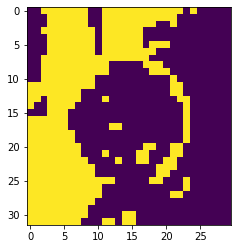

In [56]:
print(gtrsb_paths[12])
image = cv2.imread("../input/gtsrb-german-traffic-sign/" + gtrsb_paths[12])
image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
if image is None:
    print("Failed to load iamge.")
    
peaks, _ = dominant_color_counts(image)
for peak in peaks:
    mask = (abs(image[:,:,0] - peak[0]) < 20).astype(np.uint8)
    plt.imshow(mask)


## Color data <a name="color_data"></a>

In [9]:
def dominant_color(img, n_colors=3):
    twisted = np.float32(img.reshape(-1, 3))

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
    flags = cv2.KMEANS_RANDOM_CENTERS

    _, labels, palette = cv2.kmeans(twisted, n_colors, None, criteria, 10, flags)
    _, counts = np.unique(labels, return_counts=True)
    return palette[np.argmax(counts)]

def dominant_color_counts(img, n_colors=3):
    twisted = np.float32(img.reshape(-1, 3))

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
    flags = cv2.KMEANS_RANDOM_CENTERS

    _, labels, palette = cv2.kmeans(twisted, n_colors, None, criteria, 10, flags)
    _, counts = np.unique(labels, return_counts=True)
    return palette, counts

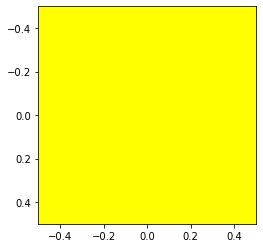

In [21]:
im = cv2.imread("./manual_dataset/stop/gir_00011.jpeg")
dom = dominant_color(im)
dom = dom.reshape(1,1,3)
dom = cv2.cvtColor(dom, cv2.COLOR_HSV2RGB)
plt.imshow(dom)

In [22]:
data_path = "./manual_dataset/"

avg_color = []
dom_color = []
labels = []

dirs = os.listdir(data_path)
for i, folder in enumerate(dirs):
    print(i, folder)
    for filename in os.listdir(data_path + folder):
        img = cv2.imread(os.path.join(data_path + folder,filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            avg_color.append(img.mean(axis=0).mean(axis=0))
            dom_color.append(dominant_color(img))
            labels.append(i)

0 obligacio_recte
1 obligacio_esq
2 obligacio_esq_davant
3 limit_10
4 prohibit_aparcar
5 stop
6 no_senyal
7 prohibit_girar_esquerra
8 8t
9 limit_30
10 aparcament
11 prohibit_parar_estacionar
12 prohibit_passar
13 pas_vianants
14 obligacio_esq_dreta


### Learning Vector Quantization amb color data <a name="lvm_color_data"></a>

In [24]:
#Cal comprovar si la implementació és correcta, hi ha una llibreria a github de jonathanrsmjtk que ho implementa

def lvq3_train(data, labels, a, b, max_ep, min_a, e):
    X = data
    y = labels
    c, train_idx = np.unique(y, True)
    r = c
    W = X[train_idx].astype(np.float64)
    train = np.array([e for i, e in enumerate(zip(X, y)) if i not in train_idx])
    X = train[:, 0]
    y = train[:, 1]
    ep = 0

    while ep < max_ep and a > min_a:
        for i, x in enumerate(X):
            d = [math.sqrt(sum((w - x) ** 2)) for w in W]
            min_1 = np.argmin(d)

            min_2 = 0
            dc = float(np.amin(d))
            dr = 0
            min_2 = d.index(sorted(d)[1])
            dr = float(d[min_2])
            if c[min_1] == y[i] and c[min_1] != r[min_2]:
                W[min_1] = W[min_1] + a * (x - W[min_1])

            elif c[min_1] != r[min_2] and y[i] == r[min_2]:
                if dc != 0 and dr != 0:

                    if min((dc/dr),(dr/dc)) > (1-e) / (1+e):
                        W[min_1] = W[min_1] - a * (x - W[min_1])
                        W[min_2] = W[min_2] + a * (x - W[min_2])
            elif c[min_1] == r[min_2] and y[i] == r[min_2]:
                W[min_1] = W[min_1] + e * a * (x - W[min_1])
                W[min_2] = W[min_2] + e * a * (x- W[min_2])
        a = a * b
        ep += 1
    return W, c

def lvq3_test(x, W):
    
    W, c = W
    d = [math.sqrt(sum((w - x) ** 2)) for w in W]

    return c[np.argmin(d)]

In [24]:
#avg_color_int = np.uint8(avg_color)
np_labels = np.uint8(labels)

#a = avg_color_int[:,2]
a = np.uint8(avg_color)


In [25]:
rand = np.random.RandomState(42)
shuffle = rand.permutation(np_labels.size)
a_sh = a[shuffle]
np_labels_sh = np_labels[shuffle]

train_a = a_sh[:3000]
test_a = a_sh[3000:]

train_labels = np_labels_sh[:3000]
test_labels = np_labels_sh[3000:]

In [26]:
W = lvq3_train(train_a, train_labels, 0.3, 0.2, 100, 0.001, 0.3)
print(W)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == "__main__":


(array([[ 87.34353439, 134.83882526, 127.31088987],
       [ 91.89976677, 136.86239737, 167.68698228],
       [ 90.06639568, 149.68439494, 151.87946311],
       [ 95.7294418 ,  87.08331489, 171.61267133],
       [106.45154943,  34.02413976, 203.37461524],
       [101.58113786,  27.36214496, 151.73831103],
       [ 86.94364108, 132.29629395,  87.77027818],
       [ 33.23144625,  39.81070155, 111.49908689],
       [108.98427384,  77.30885415, 182.23209804],
       [ 57.66854586,  80.19160543, 158.44120953],
       [ 61.00966428,  77.29025634, 116.80584856],
       [123.86783142, 106.66809008,  84.790674  ],
       [111.35586871,  76.15250946, 128.86943942],
       [105.68441105,  68.19666813, 102.4321266 ],
       [ 88.17930206,  66.68416939,  96.000512  ]]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
      dtype=uint8))


Error:  35.08005822416303 %


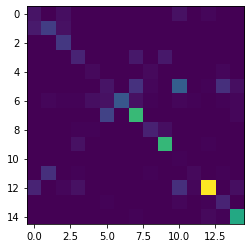

In [27]:
predict = [lvq3_test(color, W) for color in test_a]

error = (test_labels != predict).mean()
print("Error: ", error*100, "%")
confussion = np.zeros((15,15))
for i, j in zip(test_labels, predict):
    confussion[i,j] += 1
plt.imshow(confussion)


## Segmentació automàtica per color <a name="col_seg"></a>

### Directe per thresholds (gomez_thresholds) <a name="man_thresh"></a>

In [4]:
th_r1 = 5
th_r2 = 150
th_b1 = 145 
th_b2 = 135
th_y1 = 10
th_y2 = 30
th_y3 = 150

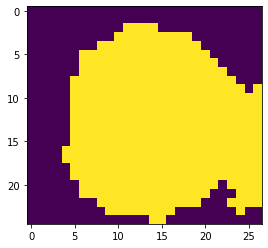

In [14]:
im = cv2.imread("./manual_dataset/stop/bar_00560.jpeg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
mask1 = (im[..., 0] <= th_r1).astype(np.uint8)
mask2 = (im[..., 0] >= th_r2).astype(np.uint8)
mask = cv2.bitwise_or(mask1, mask2)
plt.imshow(mask)

In [11]:
#!pip install ipympl
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [4]:
from IPython.core.display import display, HTML

%matplotlib nbagg
im = cv2.imread("./manual_dataset/obligacio_recte/bar_00164.jpeg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
plt.imshow(im)

<IPython.core.display.Javascript object>

In [18]:
!jupyter labextension list

JupyterLab v3.2.9
/opt/conda/share/jupyter/labextensions
        nbdime-jupyterlab v2.1.1 enabled OK
        jupyterlab-jupytext v1.3.8+dev enabled OK (python, jupytext)
        jupyterlab_pygments v0.2.2 enabled OK (python, jupyterlab_pygments)
        jupyter-threejs v2.4.0 enabled OK (python, pythreejs)
        bqplot v0.5.37 enabled OK (python, bqplot)
        jupyter-vuetify v1.8.4 enabled OK
        jupyter-vue v1.8.0 enabled OK
        jupyter-matplotlib v0.9.0 enabled OK
        jupyterlab-datawidgets v7.1.2 enabled OK
        jupyter-webrtc v0.6.0 enabled OK
        jupyter-leaflet v0.17.1 enabled OK
        catboost-widget v1.0.0 enabled OK
        jupyterlab-plotly v5.10.0 enabled OK
        @jupyter-widgets/jupyterlab-manager v3.1.1 enabled OK (python, jupyterlab_widgets)
        @jupyterlab/server-proxy v3.2.1 enabled OK
        @jupyterlab/git v0.37.1 enabled OK (python, jupyterlab-git)
        @krassowski/jupyterlab-lsp v3.10.2 enabled OK (python, jupyterlab-lsp)
       

## Gabor filters <a name="gabor"></a>


In [10]:
import lm_filters
filter_bank = lm_filters.makeLMfilters() 
filter_bank = np.moveaxis(filter_bank, -1, 0)

def visualize_filters(im,  filter_bank, n_filters=5):
    # Build an array with the absolute value of the convolution of the image for each filter
    masked = [np.abs(cv2.filter2D(im, cv2.CV_8UC3, fil)) for fil in filter_bank[:n_filters]]
    #P rint them whith the correspondig filter under 
    print_images(masked + list(filter_bank[:n_filters]), ncols=n_filters, colormap='gray')
    
def extract_features(image, filter_bank, n_filters=None):
    if n_filters == None:
        n_filters = len(filter_bank) #If no number of filters is given, use all of them
    
    masked = [np.abs(cv2.filter2D(image, cv2.CV_8UC3, fil)) for fil in filter_bank[:n_filters]] #Compute the absoute value of the convolutions
    features = np.asarray([np.mean(img) for img in masked]) #Then compute the mean for each convolution
    return features
    
#cv2.getGaborKernel(ksize, sigma, theta, lambda, gamma, psi, ktype)
# ksize - size of gabor filter (n, n)
# sigma - standard deviation of the gaussian function
# theta - orientation of the normal to the parallel stripes
# lambda - wavelength of the sunusoidal factor
# gamma - spatial aspect ratio
# psi - phase offset
# ktype - type and range of values that each pixel in the gabor kernel can hold
"""n = 20

g_kernel = cv2.getGaborKernel((n, n), 8.0, np.pi/2, 10.0, 0.5, 0, ktype=cv2.CV_32F)

"""
img = cv2.imread('./manual_dataset/prohibit_girar_esquerra/gir_00038.jpeg')

img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (32,32))
visualize_filters(img, filter_bank)
#filtered_img = cv2.filter2D(img, cv2.CV_8UC3, g_kernel)


LM filters imported, the shape of the filter bank is:  (49, 49, 48)


error: OpenCV(4.5.4) /tmp/pip-req-build-jpmv6t9_/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


#### Entrenant una LVQ (madani_color_LVQ)

In [44]:
import pandas as pd
import os
data = pd.read_csv(r'../input/hsv-samples/red.csv', names=["h", "s", "v"])
df = pd.DataFrame(data)

colors = []
labels = []

for i, file in enumerate(os.listdir("../input/hsv-samples/")):
    print(file, i)
    if i == 2 or i == 1:
        continue
    data = pd.read_csv("../input/hsv-samples/" + file, names=["h", "s", "v"])
    df = pd.DataFrame(data)
    for _, row in df.iterrows():
        colors.append([row[0], row[1]])
        labels.append(i)
        

#for i, row in df.iterrows():

blue.csv 0
background.csv 1
black.csv 2
red.csv 3


In [51]:
np_colors = np.uint8(colors)
np_labels = np.uint8(labels)

rand = np.random.RandomState(42)
shuffle = rand.permutation(np_labels.size)
print(np_labels.size)
np_colors_sh = np_colors[shuffle]
np_labels_sh = np_labels[shuffle]

train_colors = np_colors_sh[:400]
test_colors = np_colors_sh[400:]

train_labels = np_labels_sh[:400]
test_labels = np_labels_sh[400:]

475


In [52]:
W = lvq3_train(train_colors, train_labels, 0.3, 0.2, 2000, 0.0001, 0.3)
print(W)

(array([[ 83.3930465 , 251.06892359],
       [124.63182571, 140.08227239]]), array([0, 3], dtype=uint8))


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == "__main__":


Error:  18.666666666666668 %


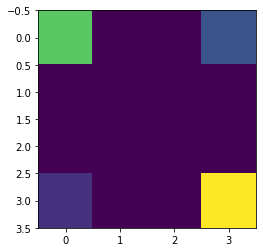

In [53]:
predict = [lvq3_test(color, W) for color in test_colors]

error = (test_labels != predict).mean()
print("Error: ", error*100, "%")
confussion = np.zeros((4,4))
for i, j in zip(test_labels, predict):
    confussion[i,j] += 1
plt.imshow(confussion)


### HSET LUT's (gomez_thresholds) <a name="lut"></a>

'\nlut_red = np.zeros(256,dtype=np.uint8)\n\nhr_min = 180/256 * 11\nhr_max = 180/256 * 224\n\nfor i in range(180):\n    if i <= hr_min:\n        lut_red[i] = 179 - 179*i/hr_min\n    if i >= hr_max:\n        lut_red[i] = 179/(179-hr_max) *(i-hr_max)\nplt.plot(lut_red)\n'

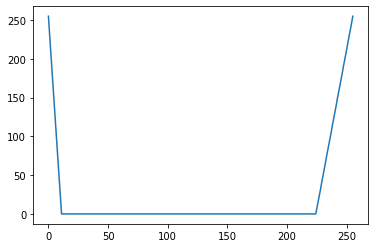

In [153]:

lut_red = np.zeros(256,dtype=np.uint8)

hr_min = 11
hr_max = 224

for i in range(256):
    if i <= hr_min:
        lut_red[i] = 255 - 255*i/hr_min
    if i >= hr_max:
        lut_red[i] = 255/(255-hr_max) *(i-hr_max)
plt.plot(lut_red)
"""
lut_red = np.zeros(256,dtype=np.uint8)

hr_min = 180/256 * 11
hr_max = 180/256 * 224

for i in range(180):
    if i <= hr_min:
        lut_red[i] = 179 - 179*i/hr_min
    if i >= hr_max:
        lut_red[i] = 179/(179-hr_max) *(i-hr_max)
plt.plot(lut_red)
"""

'\nlut_blue = np.zeros(256,dtype=np.uint8)\n\nhb_min = 180/256 *128\nhb_top = 180/256 *150\nhb_max = 180/256 * 180\n\nfor i in range(180):\n    if i >= hb_min and i <= hb_top:\n        lut_blue[i] = 179/(hb_top - hb_min) * (i - hb_min)\n    if i > hb_top and i <= hb_max:\n        lut_blue[i] = 179 - 179/(hb_max - hb_top) *(i-hb_top)\nplt.plot(lut_blue)\n'

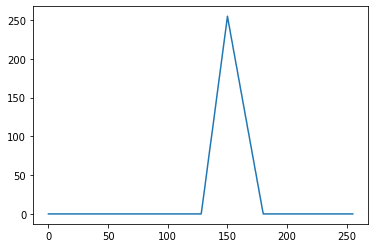

In [154]:
lut_blue = np.zeros(256,dtype=np.uint8)

hb_min = 128
hb_top = 150
hb_max = 180

for i in range(256):
    if i >= hb_min and i <= hb_top:
        lut_blue[i] = 255/(hb_top - hb_min) * (i - hb_min)
    if i > hb_top and i <= hb_max:
        lut_blue[i] = 255 - 255/(hb_max - hb_top) *(i-hb_top)
plt.plot(lut_blue)
"""
lut_blue = np.zeros(256,dtype=np.uint8)

hb_min = 180/256 *128
hb_top = 180/256 *150
hb_max = 180/256 * 180

for i in range(180):
    if i >= hb_min and i <= hb_top:
        lut_blue[i] = 179/(hb_top - hb_min) * (i - hb_min)
    if i > hb_top and i <= hb_max:
        lut_blue[i] = 179 - 179/(hb_max - hb_top) *(i-hb_top)
plt.plot(lut_blue)
"""

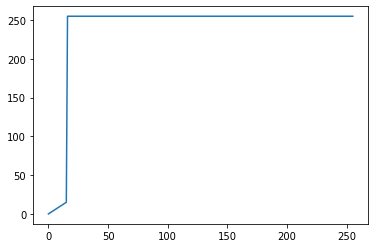

In [161]:
lut_sr = np.ones(256,dtype=np.uint8)*255
sat_red = 15

for i in range(256):
    if i <= sat_red:
        lut_sr[i] = i
plt.plot(lut_sr)

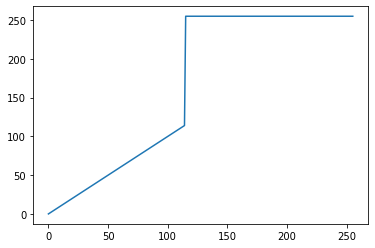

In [162]:
lut_sb = np.ones(256,dtype=np.uint8)*255
sat_blue = 114

for i in range(256):
    if i <= sat_blue:
        lut_sb[i] = i
plt.plot(lut_sb)

In [163]:
identity = np.arange(256, dtype = np.dtype('uint8'))
total_lut_red = np.dstack((lut_red, lut_sr, identity),)
total_lut_blue = np.dstack((lut_blue, lut_sb, identity))

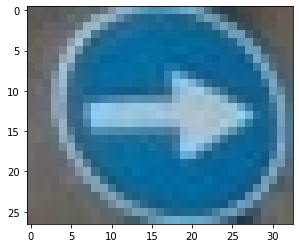

In [195]:
im = cv2.imread("./manual_dataset/obligacio_esq/00037.jpeg")
img_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
img = cv2.cvtColor(im, cv2.COLOR_BGR2HSV_FULL)
img_red = cv2.LUT(img, total_lut_red)
img_blue = cv2.LUT(img, total_lut_blue)

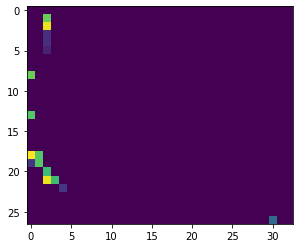

In [196]:
plt.imshow(img_red[..., 0]*img_red[..., 1])

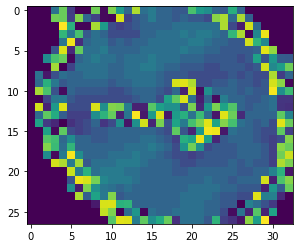

In [197]:
plt.imshow(img_blue[..., 0]*img_blue[...,1])

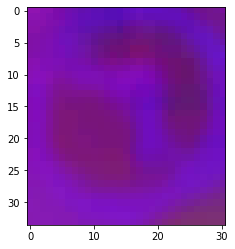

In [116]:
im = cv2.bitwise_not(im)
im_hsv = cv2.cvtColor(im,  cv2.COLOR_BGR2HSV)
plt.imshow(im_hsv)


### Probability functions (Gaussianes centrades en el color)<a name="gauss"></a>

In [11]:
def hd_blue(val, mean=170, denom=30):
    num = -np.square(val-mean, dtype='int64') #Si això no és int64 té overflow i se'n va als negatius!!!
    frac = num/(denom**2)
    return np.exp(frac)

def hd_red(val, mean1=0, mean2=255, denom=20):
    num1 = -np.square(val-mean1, dtype='int64')
    frac1 = num1/(denom**2)
    
    num2 = -np.square(val-mean2, dtype='int64')
    frac2 = num2/(denom**2)
    
    return np.exp(frac1) + np.exp(frac2)

def hd_yellow(val, mean=20, denom=20):
    num = -np.square(val-mean, dtype='int64')
    frac = num/(denom**2)
    return np.exp(frac)

def sd(val, mean=255, denom=115):
    center = val-mean
    num = -np.square(val-mean, dtype='int64')
    frac = num/(denom**2)
    return np.exp(frac)

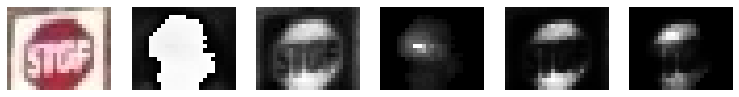

[239  51 255]


In [37]:
im = cv2.imread("./manual_dataset/stop/bar_00559.jpeg")
#im = cv2.imread("./jpeg/image.000353.jpg")
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.cvtColor(im, cv2.COLOR_BGR2HSV_FULL)
im = im.astype(np.int16)
fact1 = hd_blue(im[...,0], mean=170,denom=30)
fact2 = sd(im[...,1])
prod = np.multiply(fact1, fact2)
print_images([im_rgb, im[...,0], im[...,1], fact1, fact2, prod], colormap='gray')
print(im[10,10])

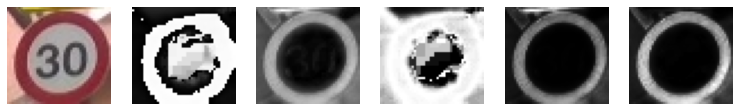

In [49]:
#im = cv2.imread("./manual_dataset/pas_vianants/gir_01899.jpeg")
im = cv2.imread("./manual_dataset/limit_30/02676.jpeg")
#im = cv2.imread("./manual_dataset/stop/gir_00050.jpeg")
#im = cv2.imread("./manual_dataset/stop/bar_00559.jpeg")
#im = cv2.imread("../input/gtsrb-german-traffic-sign/Test/00133.png")
#im = cv2.resize(im, (50,50))
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.cvtColor(im, cv2.COLOR_BGR2HSV_FULL)
im = im.astype(np.int16)
fact1 = hd_red(im[...,0])
fact2 = sd(im[...,1])
prod = np.multiply(fact1, fact2)
print_images([im_rgb, im[...,0], im[...,1], fact1, fact2, prod], colormap='gray')


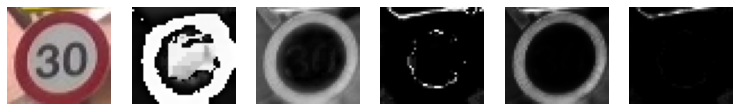

[255 152 111]


In [39]:
#im = cv2.imread("./manual_dataset/pas_vianants/gir_01899.jpeg")
im = cv2.imread("./manual_dataset/limit_30/02676.jpeg")
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.cvtColor(im, cv2.COLOR_BGR2HSV_FULL)
im = im.astype(np.int16)
fact1 = hd_yellow(im[...,0], denom=5)
fact2 = sd(im[...,1])
prod = np.multiply(fact1, fact2)
print_images([im_rgb, im[...,0], im[...,1], fact1, fact2, prod], colormap='gray')
print(im[10,10])

In [12]:
def get_color(image):
    im = cv2.cvtColor(image, cv2.COLOR_BGR2HSV_FULL)
    im = im.astype(np.int16)
    
    saturation = sd(im[...,1])
    blue = np.multiply(hd_blue(im[...,0]), saturation)
    red = np.multiply(hd_red(im[...,0]), saturation)
    yellow = np.multiply(hd_yellow(im[...,0]), saturation)
    
    colors = np.array([blue, red, yellow])
    sums = np.array([arr.sum() for arr in colors])
    #print(sums)
    index = np.argmax(sums)
    
    mask = colors[index]
    
    mask[mask < 0.25] = 0
    mask = (mask*255).astype(np.uint8)
    
    #return index, mask
    return index, mask
    

0


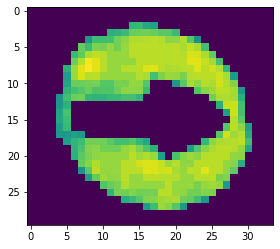

In [40]:
im = cv2.imread("./manual_dataset/aparcament/bar_00082.jpeg")
im = cv2.imread("./manual_dataset/obligacio_esq/00031.jpeg")
index, image = get_color(im)
print(index)
plt.imshow(image)

### Detecció formes per contorn <a name="contorn"></a>

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


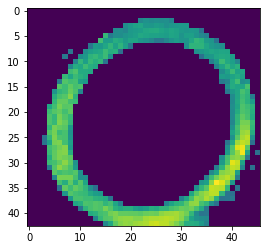

In [50]:
prod_filter = prod
prod_filter[prod < 0.25] = 0
prod_int = (prod_filter*255).astype(np.uint8)
print(prod_int)
plt.imshow(prod_int)


In [15]:
def first_nonzero(arr, axis, invalid_val=-1):
    mask = (arr!=0)
    return np.where(mask.any(axis=axis), mask.argmax(axis=axis), invalid_val)

def last_nonzero(arr, axis, invalid_val=-1):
    mask = (arr!=0)
    #val = arr.shape[axis] - np.flip(mask, axis=axis).argmax(axis=axis) - 1
    val = np.flip(mask, axis=axis).argmax(axis=axis) - 1
    return np.where(mask.any(axis=axis), val, invalid_val)

def masked_argmin(arr, limit):
    valid_idx = np.where(arr > limit)[0]
    return valid_idx[arr[valid_idx].argmin()]

def crop_signal(arr):
    min_y = masked_argmin(first_nonzero(arr, axis=0), -1)
    max_y = last_nonzero(arr, axis=0).argmax()
    
    min_x = masked_argmin(first_nonzero(arr, axis=1), -1)
    max_x = last_nonzero(arr, axis=1).argmax()
    print(min_y, max_y, min_x, max_x)
    return arr[min_y:max_y, min_x:max_x]
    
        


In [16]:
top = first_nonzero(prod_int, axis=0)
left = first_nonzero(prod_int, axis=1)
bottom = last_nonzero(prod_int, axis=0)
right = last_nonzero(prod_int, axis=1)

NameError: name 'prod_int' is not defined

NameError: name 'top' is not defined

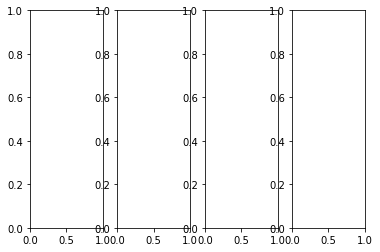

In [14]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1.plot(top)
ax2.plot(left)
ax3.plot(bottom)
ax4.plot(right)

In [55]:
test = prod_int.copy()
cnts = cv2.findContours(prod_int, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
(x,y), r = cv2.minEnclosingCircle(test)
cv2.circle(test, (int(x), int(y)), int(r), (255,0,0), 2)
plt.imshow(test)

error: OpenCV(4.5.4) /tmp/pip-req-build-jpmv6t9_/opencv/modules/imgproc/src/shapedescr.cpp:201: error: (-215:Assertion failed) count >= 0 && (depth == CV_32F || depth == CV_32S) in function 'minEnclosingCircle'


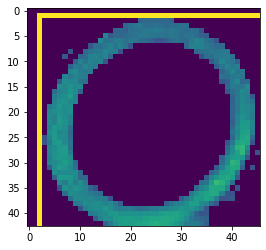

In [65]:
test = prod_int.copy()
x,y,w,h = cv2.boundingRect(prod_int)
cv2.rectangle(test,(x-1,y-1),(x+w,y+h),(255,0,0),1)
plt.imshow(test)

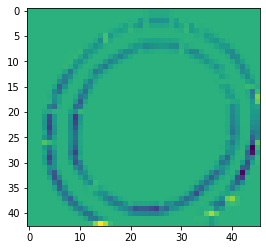

In [70]:
dst = cv2.cornerHarris(prod_int,2,3,0.04)
plt.imshow(dst)

In [ ]:
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (18, 18))

# SVM classification <a name="SVM"></a>

## Una única SVM <a name="1svm"></a>

In [46]:
data_path = "./MixedTS/"

images = []
labels = []

dirs = sorted(os.listdir(data_path))
for i, folder in enumerate(dirs):
    print(i, folder)
    for filename in os.listdir(data_path + folder):
        img = cv2.imread(os.path.join(data_path + folder,filename))
        if img is not None:
            img = cv2.resize(img, (32,32))
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            color, mask = get_color(img)
            top = first_nonzero(mask, axis=0)
            left = first_nonzero(mask, axis=1)
            bottom = last_nonzero(mask, axis=0)
            right = last_nonzero(mask, axis=1)
            #total = np.concatenate((color, top, left, bottom, extract_features(gray, filter_bank))) 
            total = np.concatenate((hog(mask), hog(gray), extract_features(gray, filter_bank)))
            images.append(total)
            labels.append(i)

0 8t
1 aparcament
2 calçada_prioritat
3 ceda
4 ciclistes
5 fi_calçada_prioritat
6 limit_10
7 limit_30
8 no_senyal
9 obligacio_esq
10 obligacio_esq_davant
11 obligacio_esq_dreta
12 obligacio_recte
13 obres
14 pas_escolar
15 pas_sense_prioritat
16 pas_vianants
17 prohibit_aparcar
18 prohibit_camions
19 prohibit_circular
20 prohibit_girar_esquerra
21 prohibit_parar_estacionar
22 prohibit_passar
23 resalto
24 rotonda
25 semafor
26 stop


In [47]:
np_hogs = np.float32(images)
np_labels = np.array(labels)
rand = np.random.RandomState(42)
shuffle = rand.permutation(np_labels.size)
np_hogs_sh = np_hogs[shuffle]
np_labels_sh = np_labels[shuffle]

np_hogs_sh_train = np_hogs_sh[:4000]
np_hogs_sh_test = np_hogs_sh[4000:]

np_labels_sh_train = np_labels_sh[:4000]
np_labels_sh_test = np_labels_sh[4000:]

svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
#svm.setKernel(cv2.ml.SVM_LINEAR) # amb cv2.ml.SVM_RBF funciona fatal
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setGamma(5.383)
svm.setC(2.67)
# svm.setNu(0.0)
# svm.setP(0.0)
# svm.setClassWeights(None)

#Entrenem la SVM
svm.train(np_hogs_sh_train, cv2.ml.ROW_SAMPLE, np_labels_sh_train)
svm.save('hog_of_mask_svm.dat')

Error:  3.7344398340248963 %


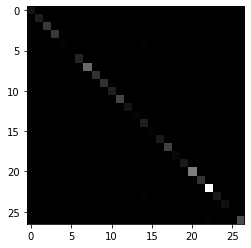

In [48]:
resp = svm.predict(np_hogs_sh_test)[1].ravel()
error = (np_labels_sh_test != resp).mean()
print("Error: ", error*100, "%")
confussion = np.zeros((27,27))
for i, j in zip(np_labels_sh_test, resp):
    confussion[i,int(j)] += 1
plt.imshow(confussion, cmap='gray')

## Color separated SVM <a name="3svm"></a>

In [13]:
blue_classes = [
    "aparcament",
"no_senyal",
"ob_esq",
"ob_esq_davant",
"ob_esq_dreta",
"ob_recte",
"pas_vianants",
"prohibit_aparcar",
"prohibit_parar_estacionar",
"rotonda"
]

red_classes = [
    "limit_tonatge",
    "ceda",
    "ciclistes",
    "limit_10",
    "limit_30",
    "no_senyal",
    "obres",
    "pas_escolar",
    "pas_sense_prior",
    "prohibit_aparcar",
    "prohibit_camions",
    "prohibit_circular",
    "prohibit_girar_esq",
    "prohibit_parar_est",
    "prohibit_passar",
    "pas_elevat",
    "semafor",
    "stop",
]

yellow_classes = [
    "calçada_prioritat",
    "fi_calçada_prioritat",
    "no_senyal"
]

### SVM blaus <a name="blaus"></a>

In [18]:
data_path = "./MixedTS_colors/blue/"

images = []
labels = []

dirs = sorted(os.listdir(data_path))
for i, folder in enumerate(dirs):
    print(i, folder)
    for filename in os.listdir(data_path + folder):
        img = cv2.imread(os.path.join(data_path + folder,filename))
        if img is not None:
            img = cv2.resize(img, (32,32))
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            color, mask = get_color(img)
            top = first_nonzero(mask, axis=0)
            left = first_nonzero(mask, axis=1)
            bottom = last_nonzero(mask, axis=0)
            right = last_nonzero(mask, axis=1)
            #total = np.concatenate((extract_features(gray, filter_bank))) 
            total = np.concatenate((hog(mask), hog(gray), extract_features(gray, filter_bank)))
            images.append(total)
            labels.append(i)

0 aparcament
1 no_senyal
2 obligacio_esq
3 obligacio_esq_davant
4 obligacio_esq_dreta
5 obligacio_recte
6 pas_vianants
7 prohibit_aparcar
8 prohibit_parar_estacionar
9 rotonda


In [32]:
np_hogs = np.float32(images)
np_labels = np.array(labels)
rand = np.random.RandomState(43)
shuffle = rand.permutation(np_labels.size)
np_hogs_sh = np_hogs[shuffle]
np_labels_sh = np_labels[shuffle]

print(np_labels_sh.shape)

np_hogs_sh_train = np_hogs_sh[:1200]
np_hogs_sh_test = np_hogs_sh[1200:]

np_labels_sh_train = np_labels_sh[:1200]
np_labels_sh_test = np_labels_sh[1200:]

svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
#svm.setKernel(cv2.ml.SVM_LINEAR) # amb cv2.ml.SVM_RBF funciona fatal
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setGamma(5.383)
svm.setC(2.67)
# svm.setNu(0.0)
# svm.setP(0.0)
# svm.setClassWeights(None)

#Entrenem la SVM
svm.train(np_hogs_sh_train, cv2.ml.ROW_SAMPLE, np_labels_sh_train)
svm.save('blue_svm_plus.dat')

(1880,)


Error:  2.5 %
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.98113208 0.         0.         0.         0.
  0.         0.00943396 0.         0.00943396]
 [0.         0.         0.9875     0.         0.         0.
  0.         0.0125     0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.03225806 0.         0.         0.96774194 0.
  0.         0.         0.         0.        ]
 [0.02222222 0.02222222 0.         0.         0.         0.95555556
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.01030928
  0.         0.97938144 0.01030928 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.02298851 0.96551724 0.01149425]
 [0.   

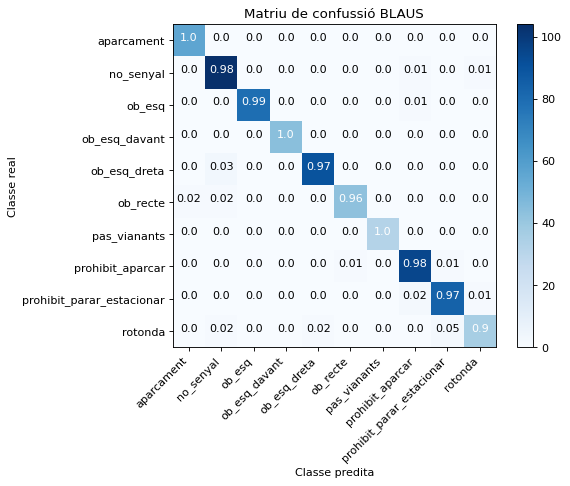

In [33]:
import itertools
resp = svm.predict(np_hogs_sh_test)[1].ravel()
error = (np_labels_sh_test != resp).mean()
print("Error: ", error*100, "%")
confussion = np.zeros((10,10))
for i, j in zip(np_labels_sh_test, resp):
    confussion[i,int(j)] += 1
#plt.imshow(confussion, cmap=plt.cm.Blues)
plt.figure(figsize=(8, 6), dpi=80)
plot_confusion_matrix(confussion, blue_classes, normalize=True,integer=False,title="Matriu de confussió BLAUS",cmap=plt.cm.Blues)


In [34]:
from sklearn import metrics
y_test = np_labels_sh_test
y_pred = resp
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))
print("Macro precission: ", metrics.precision_score(y_test, y_pred, average = 'macro'))
print("Micro precission: ", metrics.precision_score(y_test, y_pred, average = 'micro'))
print("Macro recall: ", metrics.recall_score(y_test, y_pred, average = 'macro'))
print("Micro recall: ", metrics.recall_score(y_test, y_pred, average = 'micro'))
print("Macro F1: ", metrics.f1_score(y_test, y_pred, average = 'macro'))
print("Micro F1: ", metrics.f1_score(y_test, y_pred, average = 'micro'))

Accuracy:  0.975
Macro precission:  0.9775349919029468
Micro precission:  0.975
Macro recall:  0.9736828251189404
Micro recall:  0.975
Macro F1:  0.9754837918721844
Micro F1:  0.975


### SVM Vermell <a name="vermells"></a>

In [35]:
data_path = "./MixedTS_colors/red/"

images = []
labels = []

dirs = sorted(os.listdir(data_path))
for i, folder in enumerate(dirs):
    print(i, folder)
    for filename in os.listdir(data_path + folder):
        img = cv2.imread(os.path.join(data_path + folder,filename))
        if img is not None:
            img = cv2.resize(img, (32,32))
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            color, mask = get_color(img)
            top = first_nonzero(mask, axis=0)
            left = first_nonzero(mask, axis=1)
            bottom = last_nonzero(mask, axis=0)
            right = last_nonzero(mask, axis=1)
            #total = np.concatenate((extract_features(gray, filter_bank))) 
            total = np.concatenate((hog(mask), hog(gray), extract_features(gray, filter_bank)))
            images.append(total)
            labels.append(i)

0 8t
1 ceda
2 ciclistes
3 limit_10
4 limit_30
5 no_senyal
6 obres
7 pas_escolar
8 pas_sense_prioritat
9 prohibit_aparcar
10 prohibit_camions
11 prohibit_circular
12 prohibit_girar_esquerra
13 prohibit_parar_estacionar
14 prohibit_passar
15 resalto
16 semafor
17 stop


In [41]:
np_hogs = np.float32(images)
np_labels = np.array(labels)
rand = np.random.RandomState(43)
shuffle = rand.permutation(np_labels.size)
np_hogs_sh = np_hogs[shuffle]
np_labels_sh = np_labels[shuffle]

print(np_labels_sh.shape)

np_hogs_sh_train = np_hogs_sh[:3800]
np_hogs_sh_test = np_hogs_sh[3800:]

np_labels_sh_train = np_labels_sh[:3800]
np_labels_sh_test = np_labels_sh[3800:]

svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setGamma(5.383)
svm.setC(2.67)


#Entrenem la SVM
svm.train(np_hogs_sh_train, cv2.ml.ROW_SAMPLE, np_labels_sh_train)
svm.save('red_svm_plus.dat')

(4329,)


Error:  2.0793950850661624 %
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.08333333 0.         0.         0.91666667 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.

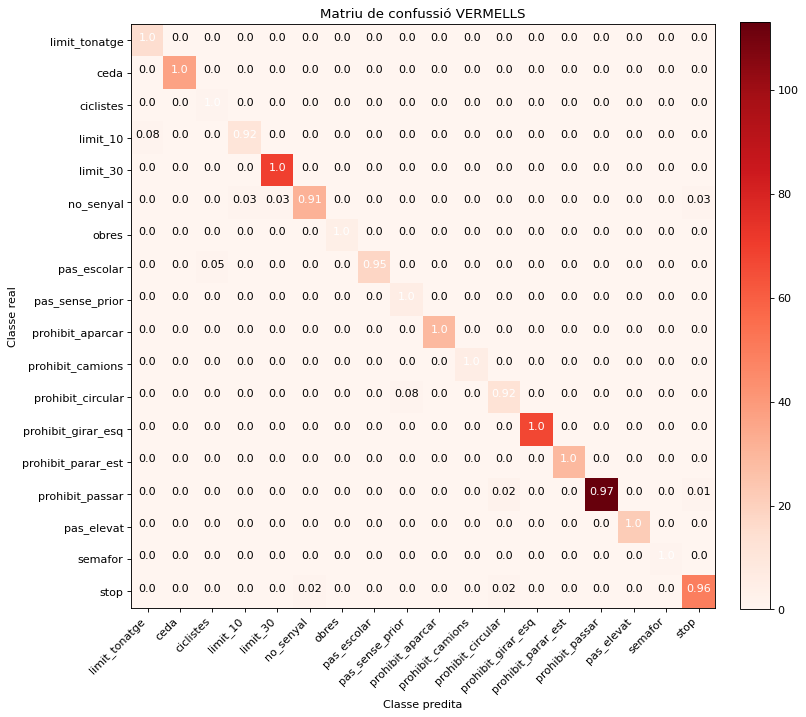

In [42]:
import itertools
resp = svm.predict(np_hogs_sh_test)[1].ravel()
error = (np_labels_sh_test != resp).mean()
print("Error: ", error*100, "%")
confussion = np.zeros((18,18))
for i, j in zip(np_labels_sh_test, resp):
    confussion[i,int(j)] += 1
#plt.imshow(confussion, cmap=plt.cm.Blues)
plt.figure(figsize=(10, 10), dpi=80)
plot_confusion_matrix(confussion, red_classes, normalize=True,integer=False,title="Matriu de confussió VERMELLS",cmap=plt.cm.Reds)


In [43]:
from sklearn import metrics
y_test = np_labels_sh_test
y_pred = resp
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))
print("Macro precission: ", metrics.precision_score(y_test, y_pred, average = 'macro'))
print("Micro precission: ", metrics.precision_score(y_test, y_pred, average = 'micro'))
print("Macro recall: ", metrics.recall_score(y_test, y_pred, average = 'macro'))
print("Micro recall: ", metrics.recall_score(y_test, y_pred, average = 'micro'))
print("Macro F1: ", metrics.f1_score(y_test, y_pred, average = 'macro'))
print("Micro F1: ", metrics.f1_score(y_test, y_pred, average = 'micro'))

Accuracy:  0.9792060491493384
Macro precission:  0.9390415888577652
Micro precission:  0.9792060491493384
Macro recall:  0.979655497857697
Micro recall:  0.9792060491493384
Macro F1:  0.9538980877698796
Micro F1:  0.9792060491493384


### SVM Grocs <a name="grocs"></a>

In [16]:
data_path = "./MixedTS_colors/yellow/"

images = []
labels = []

dirs = sorted(os.listdir(data_path))
for i, folder in enumerate(dirs):
    print(i, folder)
    for filename in os.listdir(data_path + folder):
        img = cv2.imread(os.path.join(data_path + folder,filename))
        if img is not None:
            img = cv2.resize(img, (32,32))
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            color, mask = get_color(img)
            top = first_nonzero(mask, axis=0)
            left = first_nonzero(mask, axis=1)
            bottom = last_nonzero(mask, axis=0)
            right = last_nonzero(mask, axis=1)
            #total = np.concatenate((extract_features(gray, filter_bank))) 
            total = np.concatenate((hog(mask), hog(gray), extract_features(gray, filter_bank)))
            images.append(total)
            labels.append(i)

0 calçada_prioritat
1 fi_calçada_prioritat
2 no_senyal


In [18]:
np_hogs = np.float32(images)
np_labels = np.array(labels)
rand = np.random.RandomState(43)
shuffle = rand.permutation(np_labels.size)
np_hogs_sh = np_hogs[shuffle]
np_labels_sh = np_labels[shuffle]

print(np_labels_sh.shape)

np_hogs_sh_train = np_hogs_sh[:400]
np_hogs_sh_test = np_hogs_sh[400:]

np_labels_sh_train = np_labels_sh[:400]
np_labels_sh_test = np_labels_sh[400:]

svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setGamma(5.383)
svm.setC(2.67)


#Entrenem la SVM
svm.train(np_hogs_sh_train, cv2.ml.ROW_SAMPLE, np_labels_sh_train)
svm.save('yellow_svm_plus.dat')

(566,)


Error:  2.4096385542168677 %
[[80.  2.  2.]
 [ 0.  4.  0.]
 [ 0.  0. 78.]]


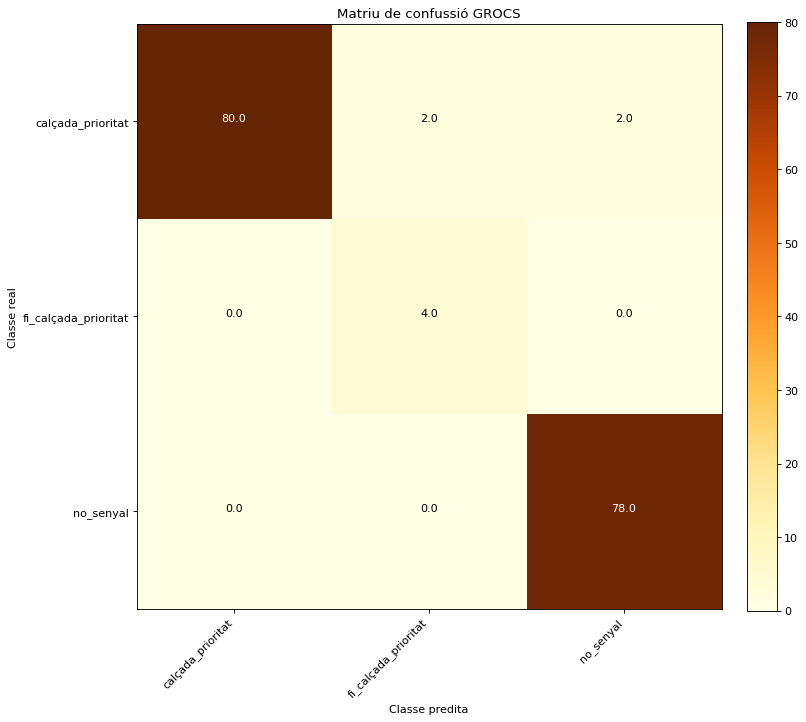

In [21]:
import itertools
resp = svm.predict(np_hogs_sh_test)[1].ravel()
error = (np_labels_sh_test != resp).mean()
print("Error: ", error*100, "%")
confussion = np.zeros((3,3))
for i, j in zip(np_labels_sh_test, resp):
    confussion[i,int(j)] += 1
plt.figure(figsize=(10, 10), dpi=80)
plot_confusion_matrix(confussion, yellow_classes, normalize=False,integer=False,title="Matriu de confussió GROCS",cmap=plt.cm.YlOrBr)

In [23]:
from sklearn import metrics
y_test = np_labels_sh_test
y_pred = resp
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))
print("Macro precission: ", metrics.precision_score(y_test, y_pred, average = 'macro'))
print("Micro precission: ", metrics.precision_score(y_test, y_pred, average = 'micro'))
print("Macro recall: ", metrics.recall_score(y_test, y_pred, average = 'macro'))
print("Micro recall: ", metrics.recall_score(y_test, y_pred, average = 'micro'))
print("Macro F1: ", metrics.f1_score(y_test, y_pred, average = 'macro'))
print("Micro F1: ", metrics.f1_score(y_test, y_pred, average = 'micro'))

Accuracy:  0.9759036144578314
Macro precission:  0.8805555555555555
Micro precission:  0.9759036144578314
Macro recall:  0.9841269841269842
Micro recall:  0.9759036144578314
Macro F1:  0.9209838427498198
Micro F1:  0.9759036144578314
